In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from scipy.stats import truncnorm
import matplotlib.pylab as pylab
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from scipy.stats import zscore
import xgboost as xgb
import lightgbm as lgb
import joblib

## Phân Tích

In [30]:
#tạo DataFrame với các cột đã được số hóa
df_raw = pd.read_csv('C:/CODE/SIC_BigData_Real-Estate-Price-Prediction/data/batdongsan/numerized/NhaO_numerized-dataset.csv',index_col=False)

In [31]:
rows  = df_raw[df_raw['MucGia'] < 200000000]
df_raw = df_raw.drop(index = rows.index)
rows  = df_raw[df_raw['MucGia'] > 200000000000]
df_raw = df_raw.drop(index = rows.index)

df_raw = df_raw.dropna(subset=['City', 'District', 'Ward','MucGia','SoTang','SoPhongNgu','SoToilet'])

df_raw = df_raw.drop(columns=['HuongBanCong','Unnamed: 0'])


In [32]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24205 entries, 5 to 45922
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DienTich    24205 non-null  float64
 1   DiaChi      24205 non-null  object 
 2   City        24205 non-null  float64
 3   District    24205 non-null  float64
 4   MucGia      24205 non-null  float64
 5   Lat         23869 non-null  float64
 6   Long        23869 non-null  float64
 7   MatTien     17245 non-null  float64
 8   PhapLy      22027 non-null  float64
 9   DuongVao    15305 non-null  float64
 10  HuongNha    7950 non-null   float64
 11  SoTang      24205 non-null  float64
 12  SoPhongNgu  24205 non-null  float64
 13  SoToilet    24205 non-null  float64
 14  NoiThat     17227 non-null  float64
 15  Ward        24205 non-null  float64
dtypes: float64(15), object(1)
memory usage: 3.1+ MB


In [33]:
df_raw = df_raw.drop(columns=['Lat','Long'])

In [34]:
# Hàm để sinh giá trị ngẫu nhiên có giới hạn trong khoảng cố định
def truncated_normal(mean, std, lower, upper, size):
    return truncnorm(
        (lower - mean) / std, (upper - mean) / std, loc=mean, scale=std).rvs(size)

# Hàm để điền các giá trị bị thiếu trong một cột số
def fill_missing_with_random(column):
    if column.dtype.kind in 'biufc':  # Kiểm tra nếu cột là số
        # Tính trung bình và độ lệch chuẩn của cột (bỏ qua giá trị bị thiếu)
        mean = np.mean(column.dropna())
        std = np.std(column.dropna())
        
        # Xác định vị trí các giá trị bị thiếu
        missing_indices = np.where(column.isnull())[0]
        
        # Sinh giá trị ngẫu nhiên nếu cột đó có các giá trị là giá trị phân loại (như số cho 8 hướng)
        if column.name == 'HuongNha':
            random_data = truncated_normal(mean, std, 1, 8, len(missing_indices))
        elif column.name == 'NoiThat':
            random_data = truncated_normal(mean, std, 0, 3, len(missing_indices))
        else:
            # Sinh giá trị ngẫu nhiên từ phân phối chuẩn
            random_data = np.random.normal(loc=mean, scale=std, size=len(missing_indices))
            # Đảm bảo không có giá trị âm
            random_data = np.abs(random_data)
        
        # Điền giá trị bị thiếu bằng các giá trị ngẫu nhiên đã sinh ra
        column.iloc[missing_indices] = random_data
        
    return column

def zero_round(value):
    if value < 0.5:
        return 0
    elif value < 1:
        return 1
    else:
        return np.floor(value)

df_raw['HuongNha'] = fill_missing_with_random(df_raw['HuongNha'])
df_raw['NoiThat'] = fill_missing_with_random(df_raw['NoiThat'])
df_raw['PhapLy'] = fill_missing_with_random(df_raw['PhapLy'])

# Làm tròn giá trị cho cột NoiThat, PhapLy, HuongNha
df_raw['NoiThat'] = df_raw['NoiThat'].apply(zero_round)
df_raw['PhapLy'] = df_raw['PhapLy'].apply(zero_round)
df_raw['HuongNha'] = np.floor(df_raw['HuongNha'])



C:\Users\quanp\AppData\Local\Temp\ipykernel_17216\2366744942.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.iloc[missing_indices] = random_data
C:\Users\quanp\AppData\Local\Temp\ipykernel_17216\2366744942.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.iloc[missing_indices] = random_data
C:\Users\quanp\AppData\Local\Temp\ipykernel_17216\2366744942.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.iloc

In [35]:
df_raw.describe()

,DienTich,City,District,MucGia,MatTien,PhapLy,DuongVao,HuongNha,SoTang,SoPhongNgu,SoToilet,NoiThat,Ward
count,24205.000000,24205.000000,24205.000000,2.420500e+04,17245.000000,24205.000000,15305.000000,24205.000000,24205.000000,24205.000000,24205.000000,24205.000000,24205.000000
mean,107.193584,42.764264,433.928445,1.665236e+10,6.506114,1.088288,11.098968,4.516711,3.897583,5.297335,5.254617,1.871886,15532.489899
std,172.320227,36.598464,344.943141,2.170678e+10,5.251218,0.535098,13.343213,1.873438,1.752670,5.997421,6.296579,0.737640,12223.951486
min,0.280000,1.000000,1.000000,3.000000e+08,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,50.000000,1.000000,8.000000,5.500000e+09,4.000000,1.000000,5.000000,3.000000,3.000000,3.000000,3.000000,2.000000,328.000000
50%,73.500000,54.000000,555.000000,9.500000e+09,5.000000,1.000000,8.000000,5.000000,4.000000,4.000000,4.000000,2.000000,22045.000000
75%,110.000000,79.000000,766.000000,1.800000e+10,7.000000,1.000000,13.500000,6.000000,5.000000,5.000000,5.000000,2.000000,26968.000000
max,12468.000000,96.000000,964.000000,2.000000e+11,265.000000,4.000000,800.000000,8.000000,24.000000,188.000000,188.000000,3.000000,31999.000000


In [36]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24205 entries, 5 to 45922
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DienTich    24205 non-null  float64
 1   DiaChi      24205 non-null  object 
 2   City        24205 non-null  float64
 3   District    24205 non-null  float64
 4   MucGia      24205 non-null  float64
 5   MatTien     17245 non-null  float64
 6   PhapLy      24205 non-null  float64
 7   DuongVao    15305 non-null  float64
 8   HuongNha    24205 non-null  float64
 9   SoTang      24205 non-null  float64
 10  SoPhongNgu  24205 non-null  float64
 11  SoToilet    24205 non-null  float64
 12  NoiThat     24205 non-null  float64
 13  Ward        24205 non-null  float64
dtypes: float64(13), object(1)
memory usage: 2.8+ MB


In [37]:
#thêm một cột LogPrice để so sánh với các cột khác. Giúp giá trị nhỏ lại để dễ trực quan
df_raw['LogPrice'] = np.log(df_raw['MucGia'])

#thêm cột USD để về sau xây dựng mô hình với giá USD hạn chế được sai số do VND quá lớn (tỉ giá đổi 25k / 1$)
df_raw['USD']=df_raw['MucGia'].astype(float)/25000

In [38]:
# Thiết kế biểu đồ
rcParams = {'xtick.labelsize':'14','ytick.labelsize':'14','axes.labelsize':'16'}

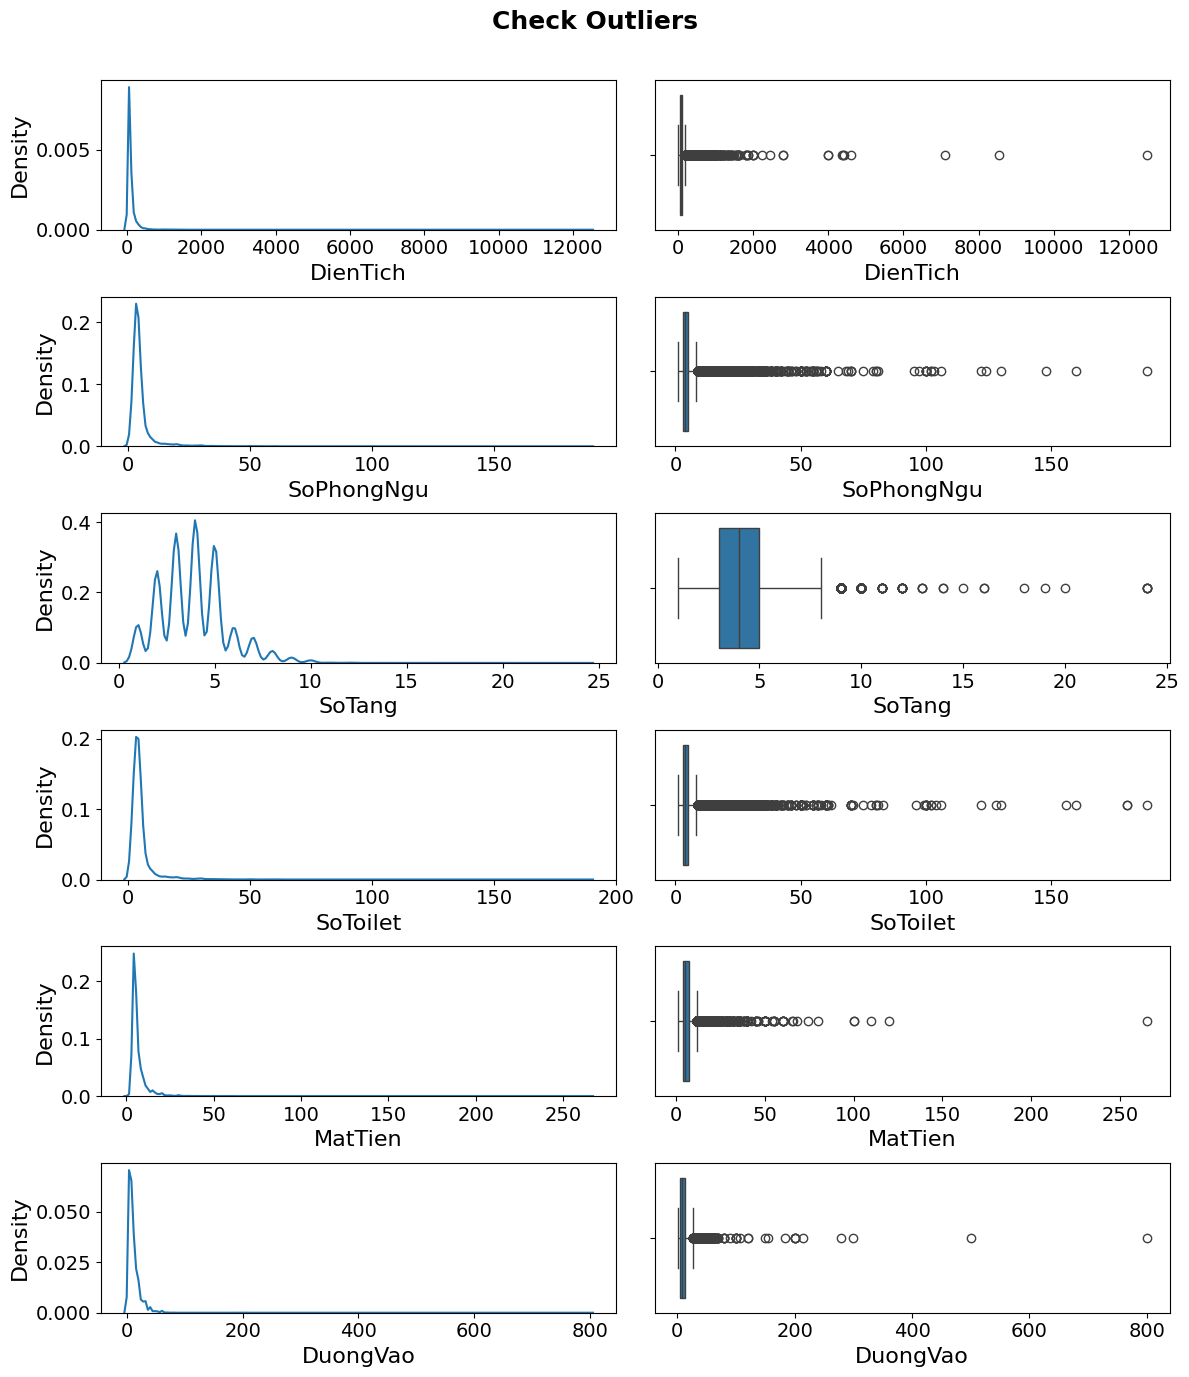

In [39]:
fig, ax = plt.subplots(6,2, figsize = (12,14))

fig.suptitle('Check Outliers', size = 18, fontweight="bold")
sns.kdeplot(ax= ax[0,0], data = df_raw, x = 'DienTich')
sns.boxplot(ax= ax[0,1], data = df_raw, x = 'DienTich')
sns.kdeplot(ax= ax[1,0], data = df_raw, x = 'SoPhongNgu')
sns.boxplot(ax= ax[1,1], data = df_raw, x = 'SoPhongNgu')
sns.kdeplot(ax= ax[2,0], data = df_raw, x = 'SoTang')
sns.boxplot(ax= ax[2,1], data = df_raw, x = 'SoTang')
sns.kdeplot(ax= ax[3,0], data = df_raw, x = 'SoToilet')
sns.boxplot(ax= ax[3,1], data = df_raw, x = 'SoToilet')
sns.kdeplot(ax= ax[4,0], data = df_raw, x = 'MatTien')
sns.boxplot(ax= ax[4,1], data = df_raw, x = 'MatTien')
sns.kdeplot(ax= ax[5,0], data = df_raw, x = 'DuongVao')
sns.boxplot(ax= ax[5,1], data = df_raw, x = 'DuongVao')


pylab.rcParams.update(rcParams)
fig.tight_layout()
fig.subplots_adjust(top=0.93)
plt.show()

Diện Tích (DienTich):  

- Biểu Đồ Trái:  
Cho thấy phân phối lệch phải rất mạnh, với hầu hết các giá trị tập trung ở khoảng thấp.một số nhà ở có diện tích rất lớn so với phần còn lại.
- Biểu Đồ Phải:  
Các giá trị ngoại lai xuất hiện rất nhiều.  

Số Phòng Ngủ (SoPhongNgu):  

- Biểu Đồ Trái:  
Phân phối lệch phải với số lượng phòng ngủ chủ yếu từ 0 đến 25 phòng. Điều này cho thấy phần lớn các nhà ở có ít phòng ngủ, nhưng vẫn có một số ít có rất nhiều phòng ngủ.  
- Biểu Đồ Phải:  
Một số giá trị ngoại lai xuất hiện, nhưng không quá xa so với phần còn lại, cho thấy sự phân phối phòng ngủ tương đối đồng đều ngoại trừ một vài nhà ở có số phòng ngủ cao bất thường.  

Số Tầng (SoTang):  

- Biểu Đồ Trái:  
Phân phối phức tạp với nhiều đỉnh, cho thấy có sự phân loại trong dữ liệu về số tầng, có thể do những loại nhà khác nhau (nhà phố, biệt thự,...).  
- Biểu Đồ Phải:  
Một số giá trị ngoại lai, nhưng không nhiều, cho thấy số tầng là một biến có sự phân phối tương đối tập trung với một vài ngoại lệ.  

Số Toilet (SoToilet):  

- Biểu Đồ Trái:  
Phân phối lệch phải rõ rệt, với số lượng toilet chủ yếu tập trung ở mức thấp, nhưng có một vài nhà ở có số toilet rất cao.  
- Biểu Đồ Phải:  
Một số lượng giá trị ngoại lai, nhưng cũng không quá lớn, cho thấy số toilet có sự phân phối khá đều ngoại trừ một số trường hợp đặc biệt.  

Mặt Tiền (MatTien):  

- Biểu Đồ Trái:  
Phân phối lệch phải rất mạnh, với mặt tiền chủ yếu tập trung ở mức nhỏ, nhưng có một số ít trường hợp có mặt tiền rất rộng.  
- Biểu Đồ Phải:  
Các giá trị ngoại lai xuất hiện rất rõ ràng, cho thấy có một sự chênh lệch đáng kể về mặt tiền giữa các nhà ở.  

Đường Vào (DuongVao):  

- Biểu Đồ Trái:  
Phân phối lệch phải mạnh, phần lớn các giá trị tập trung ở mức thấp, chỉ một số ít có đường vào rộng lớn.  
- Biểu Đồ Phải:  
Các giá trị ngoại lai cũng khá rõ ràng, cho thấy sự khác biệt lớn trong độ rộng đường vào giữa các nhà ở.  

Kết luận:  

- Các biến trong bộ dữ liệu bất động sản này đều có xu hướng lệch phải, với hầu hết các giá trị tập trung ở mức thấp và một số ít giá trị cực đoan cao hơn đáng kể. Điều này có thể do tính chất không đồng nhất của các nhà ở, với sự khác biệt lớn về diện tích, số phòng, số tầng, số toilet, mặt tiền, và độ rộng đường vào.


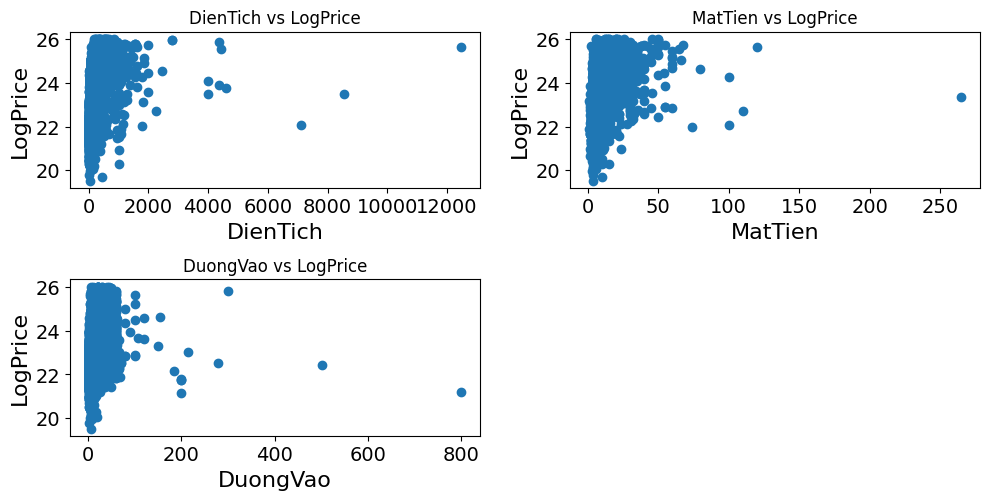

In [40]:
def scatter(x,fig):
    plt.subplot(5,2,fig)
    plt.scatter(df_raw[x],df_raw['LogPrice'])
    plt.title(x+' vs LogPrice')
    plt.ylabel('LogPrice')
    plt.xlabel(x)


plt.figure(figsize=(10,12))


scatter('DienTich', 1)
scatter('MatTien', 2)
scatter('DuongVao', 3)
plt.tight_layout()

Quan sát  
- Diện Tích vs LogPrice:  
Phần lớn các điểm dữ liệu tập trung ở phía bên trái, nơi diện tích nhỏ. Điều này cho thấy "Diện Tích" lớn thường ít phổ biến và có thể không ảnh hưởng lớn đến "LogPrice" trong phạm vi diện tích nhỏ.  
Tuy nhiên, các giá trị ngoại lai với diện tích rất lớn (> 10,000) có thể làm biến động "LogPrice" mạnh mẽ, nhưng lại là những điểm dữ liệu ít phổ biến. Những giá trị này có thể làm tăng LogPrice lên một mức đáng kể.  
- Mặt Tiền vs LogPrice:  
Tương tự, hầu hết các giá trị "Mặt Tiền" nhỏ (< 50) tập trung ở góc trái của biểu đồ, cho thấy rằng đa số nhà có mặt tiền nhỏ.  
Một số ngoại lai có "Mặt Tiền" lớn (> 100) có thể làm tăng giá trị LogPrice, nhưng những ngoại lai này là rất hiếm, và do đó có thể ảnh hưởng lớn đến trung bình nhưng không phải là xu hướng chung.  
- Đường Vào vs LogPrice:  
Biểu đồ này cho thấy đa số các điểm dữ liệu có "Đường Vào" nhỏ (< 50). Những điểm này không có mối liên hệ mạnh mẽ với LogPrice.  
Tương tự như hai biến trên, các giá trị ngoại lai ở "Đường Vào" (những đường lớn hơn 200) có thể làm tăng giá trị LogPrice  

Ảnh hưởng từ các giá trị ngoại lai:  
- Các giá trị ngoại lai ở cả ba biến này (DienTich, MatTien, DuongVao) đều có thể gây ra biến động lớn đối với LogPrice.  

Ảnh hưởng tổng quát:  
- Diện Tích: Thường có ảnh hưởng tích cực đến LogPrice, tức là khi diện tích tăng, LogPrice cũng có xu hướng tăng. Tuy nhiên, sự ảnh hưởng này có thể giảm dần khi diện tích tăng quá lớn.  
- Mặt Tiền: Cũng có ảnh hưởng tích cực, nhưng thường không mạnh bằng "Diện Tích." Tăng "Mặt Tiền" thường làm tăng LogPrice, nhưng cũng chỉ đến một mức độ nhất định.  
- Đường Vào: Ảnh hưởng đến LogPrice có thể có nhưng thường nhỏ hơn so với "Diện Tích" và "Mặt Tiền." Các đường lớn hơn có thể làm tăng giá trị LogPrice, nhưng không phải là một yếu tố quyết định mạnh.  

Kết luận:  
- Các biến "Diện Tích," "Mặt Tiền," và "Đường Vào" đều có ảnh hưởng nhất định đến "LogPrice," nhưng ảnh hưởng này không đồng đều. "Diện Tích" thường có ảnh hưởng mạnh nhất, theo sau là "Mặt Tiền" và cuối cùng là "Đường Vào." Các giá trị ngoại lai có thể làm tăng độ biến động của LogPrice

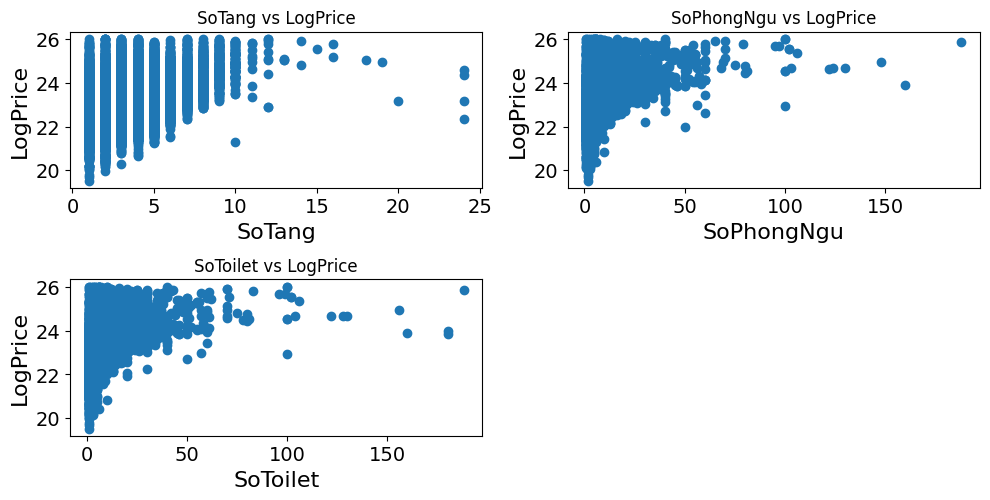

In [41]:
plt.figure(figsize=(10,12))

scatter('SoTang', 1)
scatter('SoPhongNgu', 2)
scatter('SoToilet', 3)

plt.tight_layout()

Số Tầng (SoTang) vs LogPrice:  
- Số lượng tầng tăng lên có xu hướng kéo theo sự tăng giá trị của LogPrice. Tuy nhiên, tác động này không tăng đều và có dấu hiệu dừng lại hoặc giảm dần khi số tầng vượt qua một số lượng nhất định (khoảng từ 15 tầng trở lên).  
- Một số ngoại lệ xuất hiện ở những giá trị cao hơn (từ 20 tầng trở lên), nhưng số liệu này khá ít, vì vậy có thể không đại diện cho xu hướng chung.  

Số Phòng Ngủ (SoPhongNgu) vs LogPrice:  
- Hầu hết các nhà có số phòng ngủ dưới 50, và các nhà này có mức giá LogPrice trải dài, tuy nhiên tập trung ở mức cao hơn (giá trị LogPrice từ 22 đến 26).  
- Những ngoại lệ có số phòng ngủ rất cao (trên 50, đặc biệt là trên 100) thường có giá trị LogPrice cao, nhưng những điểm này rất hiếm, cho thấy rằng yếu tố này có thể ảnh hưởng mạnh mẽ đến giá trị LogPrice trong một số trường hợp cụ thể.  
Số Toilet (SoToilet) vs LogPrice:  
- Tương tự với số phòng ngủ, số toilet tăng lên có xu hướng làm tăng giá trị LogPrice, nhưng sự tăng này không đồng đều và có nhiều ngoại lệ.  
- Các giá trị số toilet rất cao (trên 50) không thể hiện một mối quan hệ rõ ràng với LogPrice do số lượng dữ liệu ít và phân tán.  

Ảnh hưởng tổng quát:  
- Số Tầng (SoTang): Có ảnh hưởng tích cực đến LogPrice. Tuy nhiên, sau một số lượng tầng nhất định, ảnh hưởng có thể giảm hoặc không còn mạnh mẽ nữa.  
- Số Phòng Ngủ (SoPhongNgu): Cũng có tác động tích cực, nhưng sự gia tăng LogPrice do số phòng ngủ tăng dường như có giới hạn. Những căn nhà với số lượng phòng ngủ quá lớn có thể không còn làm tăng giá trị LogPrice một cách rõ rệt.
- Số Toilet (SoToilet): Có ảnh hưởng tích cực nhưng cũng có giới hạn tương tự như số phòng ngủ. Tăng số lượng toilet đến một mức độ nhất định sẽ làm tăng LogPrice, nhưng sau đó có thể giảm dần.  

Kết luận:
- "Số Tầng," "Số Phòng Ngủ," và "Số Toilet" đều có ảnh hưởng tích cực đến LogPrice, nhưng sự ảnh hưởng này không đều và có thể giảm dần khi số lượng tăng lên quá cao. Những căn nhà có số lượng phòng ngủ hoặc toilet quá lớn không chắc chắn sẽ có LogPrice cao hơn, trong khi số tầng có thể có một mức tăng ở khoảng 1 - 10 tầng, sau đó từ 15 đến 20 giá trị của những căn nhà không tăng thêm nhiều hoặc thậm chí không tăng nữa.

C:\Users\quanp\AppData\Local\Temp\ipykernel_17216\35129562.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_raw['HuongNha'], y=df_raw['USD'], palette="plasma")


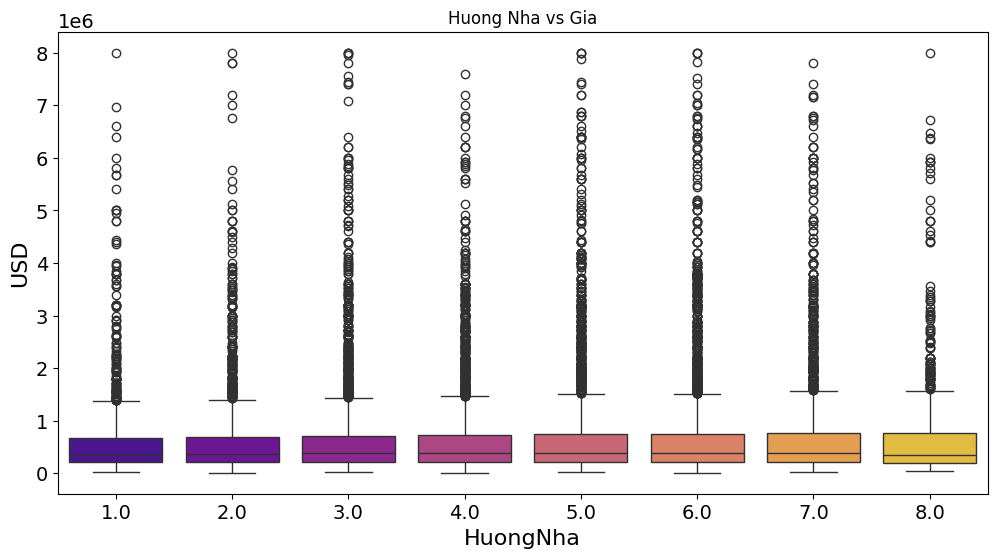

C:\Users\quanp\AppData\Local\Temp\ipykernel_17216\35129562.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_raw['NoiThat'], y=df_raw['USD'], palette="plasma")


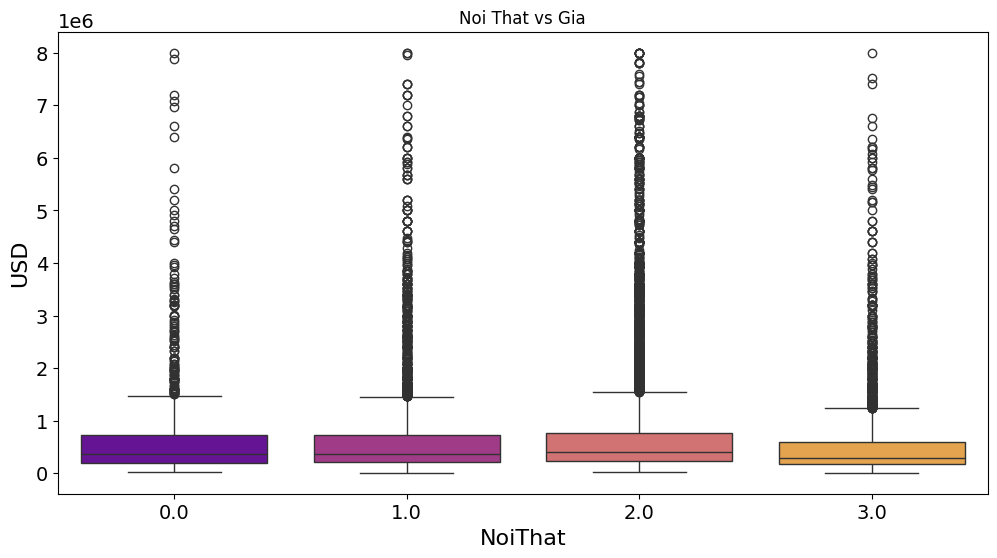

C:\Users\quanp\AppData\Local\Temp\ipykernel_17216\35129562.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_raw['PhapLy'], y=df_raw['USD'], palette="plasma")


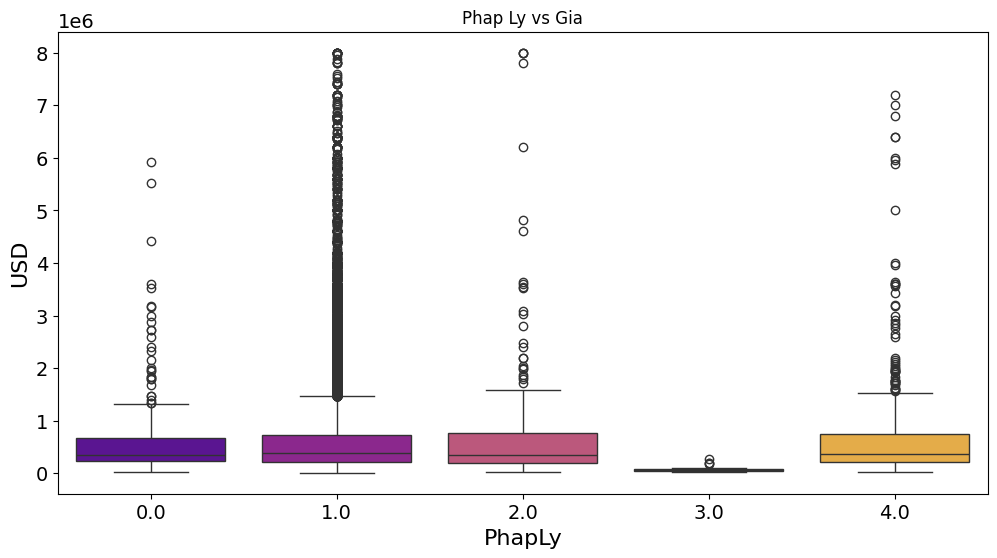

In [42]:
# Setting the figure size for the plots
plt.rcParams['figure.figsize'] = (12, 6)

# Creating the box plots

# sns.boxplot(x=df_raw['HuongBanCong'], y=df_raw['USD'], palette="plasma")
# plt.title('Huong Ban Cong vs Gia')
# plt.show()

sns.boxplot(x=df_raw['HuongNha'], y=df_raw['USD'], palette="plasma")
plt.title('Huong Nha vs Gia')
plt.show()

sns.boxplot(x=df_raw['NoiThat'], y=df_raw['USD'], palette="plasma")
plt.title('Noi That vs Gia')
plt.show()

sns.boxplot(x=df_raw['PhapLy'], y=df_raw['USD'], palette="plasma")
plt.title('Phap Ly vs Gia')
plt.show()

Hướng nhà với giá:  
- Từ biểu đồ, ta có thể thấy rằng sự khác biệt về giá giữa các hướng nhà không rõ rệt.  
- Các hướng nhà có chiều cao tương đối giống nhau và nằm ở các mức giá tương đương.  
- Mức giá trung vị (median) không khác biệt nhiều giữa các hướng nhà.  
Kết luận:  
- Có vẻ như Hướng Nhà không có ảnh hưởng lớn đến giá trị của nhà (USD).Mức giá có xu hướng phân bố tương tự bất kể hướng nhà, điều này cho thấy rằng hướng nhà có thể không phải là yếu tố quan trọng trong việc định giá  

Nội Thất với giá:  
- Biểu đồ cho thấy rằng mức giá trung vị (median) của các nhóm nội thất không khác biệt quá rõ ràng. Nội thất có thể không phải là yếu tố quyết định lớn đến giá của căn nhà.  
- Tuy nhiên, có một sự khác biệt nhẹ giữa các nhóm, trong đó giá trị trung vị có xu hướng tăng dần từ 0 đến 3. Các căn nhà có nội thất tốt hơn (giá trị nội thất cao hơn) có thể có giá cao hơn, nhưng ảnh hưởng này không quá rõ rệt.  
Kết luận:  
Nội Thất có thể có ảnh hưởng nhẹ đến giá trị của nhà (USD), nhưng ảnh hưởng này không rõ ràng và mạnh mẽ. Có khả năng nội thất là một trong nhiều yếu tố ảnh hưởng đến giá nhà, nhưng không phải là yếu tố quyết định duy nhất.  

Pháp Lý với giá:  
- Nhóm Pháp Lý = 0: Giá trị bất động sản trong nhóm này có phân bố tương đối hẹp, với một số ngoại lệ có giá trị cao hơn. Phần lớn các bất động sản trong nhóm này có giá trị dưới 2 triệu USD.  
- Nhóm Pháp Lý = 1: Đây là nhóm có sự phân bố giá trị rộng nhất, với nhiều bất động sản có giá trị cao hơn, lên tới gần 8 triệu USD. Nhóm này có nhiều bất động sản ngoại lệ với giá trị cao.  
- Nhóm Pháp Lý = 2: Mặc dù có nhiều bất động sản ngoại lệ, phần lớn giá trị của chúng vẫn nằm trong khoảng dưới 1 triệu USD.  
- Nhóm Pháp Lý = 3: Nhóm này có phân bố giá trị rất hẹp với tất cả các bất động sản có giá trị dưới 1 triệu USD.  
- Nhóm Pháp Lý = 4: Nhóm này có một số bất động sản ngoại lệ với giá trị cao hơn 4 triệu USD, nhưng phần lớn vẫn nằm trong khoảng dưới 1 triệu USD.  

Kết luận:  
- Nhóm Pháp Lý = 1 là nhóm có giá trị bất động sản cao nhất và phân bố rộng nhất, cho thấy sự đa dạng lớn về giá trị trong nhóm này.
- Các nhóm khác có giá trị bất động sản tập trung hơn và ít ngoại lệ hơn, đặc biệt là nhóm Pháp Lý = 3 và 4.
- Nhãn Pháp Lý ảnh hưởng đến giá trị của bất động sản, và nhóm Pháp Lý = 1 có thể là nhóm pháp lý có giá trị cao nhất hoặc phổ biến nhất trong thị trường.

In [43]:
# Hàm để tải dữ liệu JSON vào một từ điển
def load_dvhc_dict(file_name):
    with open(file_name, "r", encoding="utf8") as dvhc_file:
        dvhc_json = json.load(dvhc_file)
        dvhc_dict = {}

        for level_1_key, level_1 in dvhc_json.items():
            dvhc_dict[level_1_key] = level_1["name"]
            for level_2_key, level_2 in level_1["level2s"].items():
                dvhc_dict[level_2_key] = level_2["name"]
                for level_3_key, level_3 in level_2["level3s"].items():
                    dvhc_dict[level_3_key] = level_3["name"]

    return dvhc_dict

# Đường dẫn tới dữ liệu JSON
json_path = "C:/CODE/SIC_BigData_Real-Estate-Price-Prediction/data/donvihanhchinhvn/dvhcvn_2024.json"
json_path_1 = "C:/CODE/SIC_BigData_Real-Estate-Price-Prediction/data/donvihanhchinhvn/dvhcvn_2020.json"

# Tải từ điển
try:
    dvhc_dict = load_dvhc_dict(json_path)
    dvhc_dict_1 = load_dvhc_dict(json_path_1)
except KeyError as e:
    print(f"Lỗi: {e}")
    dvhc_dict = {}
    dvhc_dict_1 = {}

# Hàm để lấy tên từ ID với việc debug và chuyển đổi từ chuỗi
def get_name_from_id(id, dvhc_dict, dvhc_dict_1):
    if pd.isna(id):
        return "ID không tìm thấy"
    id_str = str(int(id)) if not isinstance(id, str) else id
    if id_str in dvhc_dict:
        return dvhc_dict[id_str]
    if id_str in dvhc_dict_1:
        return dvhc_dict_1[id_str]
    return "ID không tìm thấy"

# Hàm để định dạng ID với các số 0 đứng đầu
def format_id(id, length):
    try:
        return str(int(id)).zfill(length)  # Chuyển thành int trước khi zfill để xử lý số float
    except ValueError:
        return None  # Trong trường hợp ID không hợp lệ

# Hàm để chuyển đổi ID của thành phố, quận, và phường thành tên với định dạng và theo dõi lỗi
def convert_ids_to_names(df, dvhc_dict, dvhc_dict_1):
    # Chuyển đổi cho Thành phố
    df['City'] = df['City'].apply(lambda x: get_name_from_id(format_id(x, 2), dvhc_dict, dvhc_dict_1))
    # Chuyển đổi cho Quận
    df['District'] = df['District'].apply(lambda x: get_name_from_id(format_id(x, 3), dvhc_dict, dvhc_dict_1))
    # Chuyển đổi cho Phường
    df['Ward'] = df['Ward'].apply(lambda x: get_name_from_id(format_id(x, 5), dvhc_dict, dvhc_dict_1))
    return df

# Tạo một bản sao của df_raw
df_copy = df_raw.copy()

# Áp dụng hàm chuyển đổi vào bản sao của DataFrame
df_copy = convert_ids_to_names(df_copy, dvhc_dict, dvhc_dict_1)

In [44]:
frame1 = df_copy
bins = [40000,90000,250000,118366500]

In [45]:
def Analyst(col):
    temp = frame1.copy()
    table = temp.groupby([col])['USD'].mean()
    temp = temp.merge(table.reset_index(), how='left', on=col)
    cars_bin = ['Low', 'Medium', 'High']
    frame1['range'] = pd.cut(temp['USD_x'], bins, right=False, labels=cars_bin)
    plt.rcParams['figure.figsize'] = (18, 8)
    df = pd.DataFrame(frame1.groupby([col, 'range'])['USD'].mean().unstack(fill_value=0))
    df.plot.bar()
    plt.title('House Range vs Price')
    plt.show()

C:\Users\quanp\AppData\Local\Temp\ipykernel_17216\1922501046.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.DataFrame(frame1.groupby([col, 'range'])['USD'].mean().unstack(fill_value=0))


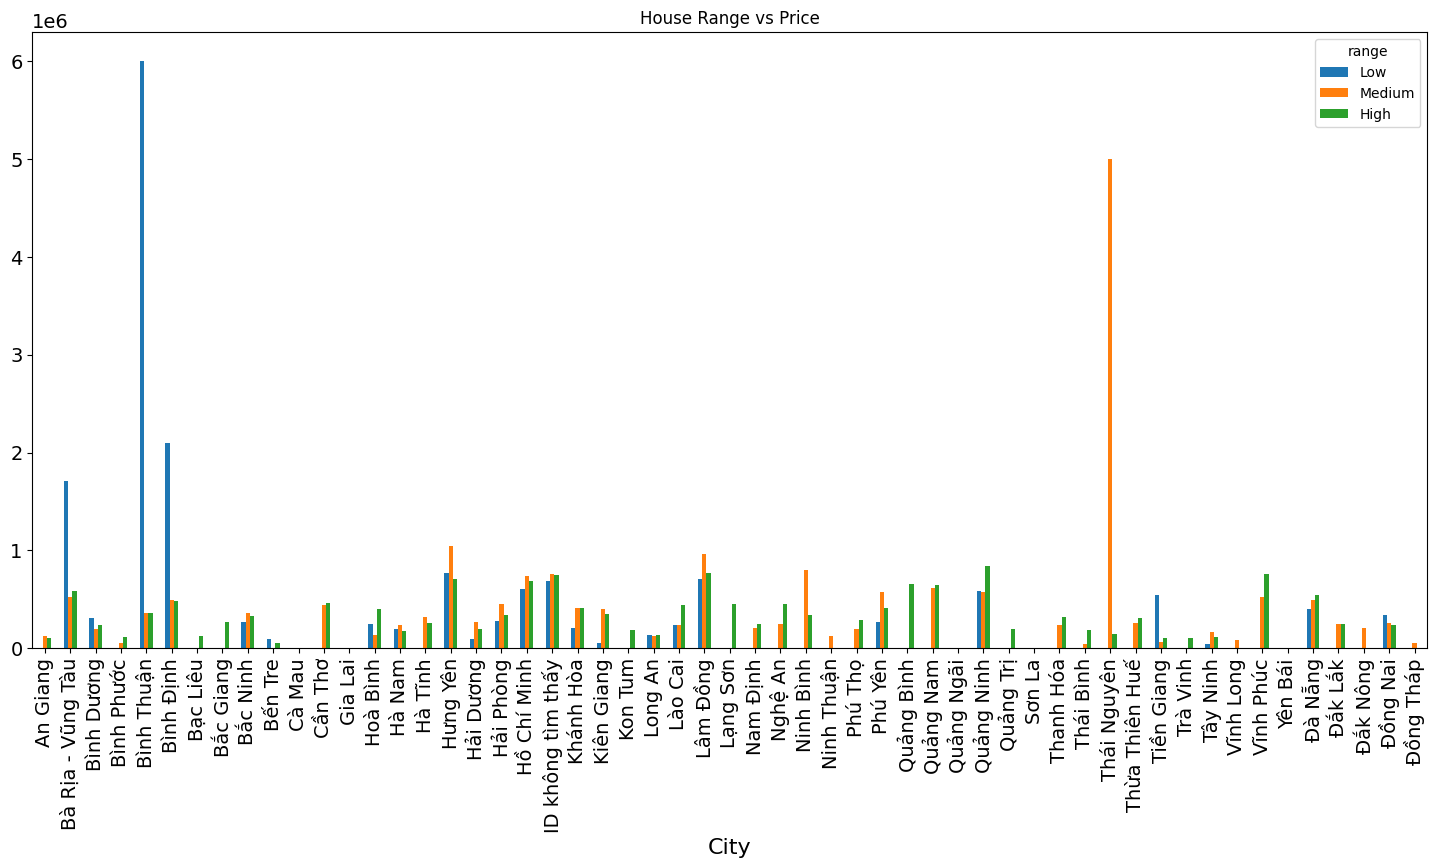

In [46]:
Analyst('City')

Đánh giá biểu đồ:  
- Thành phố Bà Rịa - Vũng Tàu: Mức giá thấp (Low) có giá trị rất cao, vượt xa các mức giá khác, thậm chí vượt qua mức giá cao (High) ở nhiều thành phố khác.  
- Thành phố Thái Bình: Mức giá trung bình (Medium) nổi bật với một bất động sản có giá trị cao nhất trong tất cả các thành phố.  
- Thành phố Bình Thuận và Ninh Thuận: Mức giá thấp (Low) chiếm ưu thế và có giá trị tương đối cao.  
- Các thành phố khác: Mức giá thấp (Low) và cao (High) có sự phân bố tương đối đồng đều, không có thành phố nào nổi bật hoàn toàn.  

Kết luận:  

- Một số thành phố như Bà Rịa - Vũng Tàu và Thái Bình có sự khác biệt lớn về giá trị bất động sản ở các mức giá khác nhau.  
- Sự chênh lệch lớn giữa các mức giá thấp (Low) và trung bình (Medium) ở một số thành phố gợi ý về sự phân hoá thị trường nhà ở.

In [47]:
# Lấy giá trị USD cao nhất
max_usd_row = df_raw.loc[df_raw['USD'].idxmax(), ['USD', 'City']]

# Lấy giá trị USD thấp nhất
min_usd_row = df_raw.loc[df_raw['USD'].idxmin(), ['USD', 'City']]

# In ra giá trị
print("Giá trị USD cao nhất:")
print(max_usd_row)

print("\nGiá trị USD thấp nhất:")
print(min_usd_row)

Giá trị USD cao nhất:
USD     8000000.0
City         79.0
Name: 2329, dtype: object

Giá trị USD thấp nhất:
USD     12000.0
City       80.0
Name: 7692, dtype: object


Bộ dữ thu được ta thấy  
thành Phố HCM có mức giá cao nhất: 8 000 000$ sấp xỉ 200 tỷ VND  
Tỉnh Long An có mức giá thấp nhất: 12 000$ sấp xỉ 300 triệu VND  
với 25 000 = 1$

In [48]:
df_raw = df_raw.drop(columns=['DiaChi'])

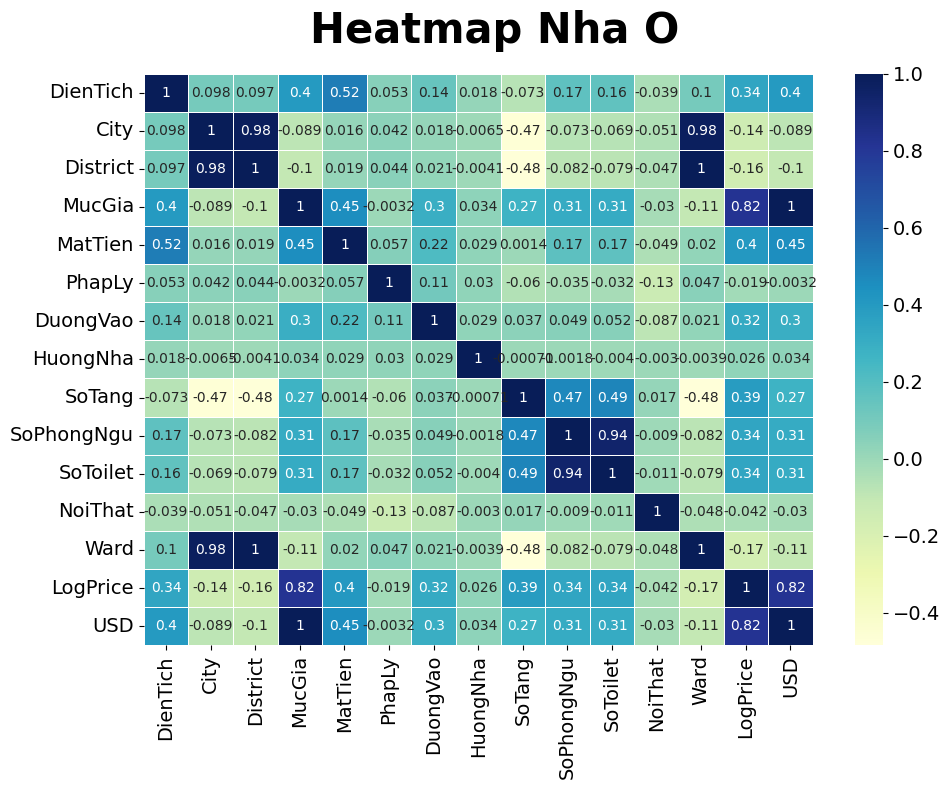

In [49]:
fig = plt.figure(figsize=(10,8))

sns.heatmap(df_raw.corr(), annot = True, cmap='YlGnBu', linewidth=.5)
fig.suptitle('Heatmap Nha O',fontsize=30, fontweight="bold")
pylab.rcParams.update(rcParams)
fig.tight_layout()
plt.show()

SoPhongNgu và SoToilet (0.94): Tương quan rất cao. Vì số lượng phòng ngủ và phòng vệ sinh thường tỷ lệ thuận với nhau.  
MatTien và DienTich (0.52): Tương quan dương. cho thấy diện tích mặt tiền (MatTien) thường lớn hơn khi diện tích tổng thể (DienTich) tăng.  
District và City (0.98): Tương quan gần như hoàn hảo. Do sự liên kết giữa quận (District) và thành phố (City) trong dữ liệu này.


In [50]:
#xóa 2 cột không cần thiết
df_raw = df_raw.drop(columns=['LogPrice','MucGia'])

In [51]:
df_raw.isna().sum()

DienTich         0
City             0
District         0
MatTien       6960
PhapLy           0
DuongVao      8900
HuongNha         0
SoTang           0
SoPhongNgu       0
SoToilet         0
NoiThat          0
Ward             0
USD              0
dtype: int64

In [52]:
#Lưu dữ liệu chuẩn hóa vào file csv
df_raw.to_csv('Standardize_House.csv')

## Xây Dựng Mô Hình

In [53]:
df_dropped_2 = pd.read_csv('C:/CODE/SIC_BigData_Real-Estate-Price-Prediction/notebooks/Standardize_House.csv',index_col=False)
df_dropped_2 = df_dropped_2.drop(columns=['Unnamed: 0'])

In [54]:
df_dropped_2.describe()

,DienTich,City,District,MatTien,PhapLy,DuongVao,HuongNha,SoTang,SoPhongNgu,SoToilet,NoiThat,Ward,USD
count,24205.000000,24205.000000,24205.000000,17245.000000,24205.000000,15305.000000,24205.000000,24205.000000,24205.000000,24205.000000,24205.000000,24205.000000,2.420500e+04
mean,107.193584,42.764264,433.928445,6.506114,1.088288,11.098968,4.516711,3.897583,5.297335,5.254617,1.871886,15532.489899,6.660946e+05
std,172.320227,36.598464,344.943141,5.251218,0.535098,13.343213,1.873438,1.752670,5.997421,6.296579,0.737640,12223.951486,8.682711e+05
min,0.280000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.200000e+04
25%,50.000000,1.000000,8.000000,4.000000,1.000000,5.000000,3.000000,3.000000,3.000000,3.000000,2.000000,328.000000,2.200000e+05
50%,73.500000,54.000000,555.000000,5.000000,1.000000,8.000000,5.000000,4.000000,4.000000,4.000000,2.000000,22045.000000,3.800000e+05
75%,110.000000,79.000000,766.000000,7.000000,1.000000,13.500000,6.000000,5.000000,5.000000,5.000000,2.000000,26968.000000,7.200000e+05
max,12468.000000,96.000000,964.000000,265.000000,4.000000,800.000000,8.000000,24.000000,188.000000,188.000000,3.000000,31999.000000,8.000000e+06


In [55]:
df_dropped_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24205 entries, 0 to 24204
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DienTich    24205 non-null  float64
 1   City        24205 non-null  float64
 2   District    24205 non-null  float64
 3   MatTien     17245 non-null  float64
 4   PhapLy      24205 non-null  float64
 5   DuongVao    15305 non-null  float64
 6   HuongNha    24205 non-null  float64
 7   SoTang      24205 non-null  float64
 8   SoPhongNgu  24205 non-null  float64
 9   SoToilet    24205 non-null  float64
 10  NoiThat     24205 non-null  float64
 11  Ward        24205 non-null  float64
 12  USD         24205 non-null  float64
dtypes: float64(13)
memory usage: 2.4 MB


In [56]:
X = df_dropped_2.drop(['USD'], axis=1)
y = df_dropped_2['USD']

In [57]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [59]:
# Lưu scaler
joblib.dump(scaler, 'scaler_House.pkl')

['scaler_House.pkl']

## Random Forest

In [60]:
# Khởi tạo và huấn luyện mô hình Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [61]:
# Dự đoán và đánh giá mô hình
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')

Root Mean Squared Error: 397723.2144591899
R² Score: 0.8070618158490638


In [62]:
# Grid Search cho tối ưu hóa siêu tham số của RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Khởi tạo mô hình RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Tìm kiếm siêu tham số tối ưu
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Huấn luyện GridSearch
grid_search.fit(X_train_scaled, y_train)

# Lấy mô hình tốt nhất
best_rf_model = grid_search.best_estimator_

# Dự đoán với mô hình tốt nhất
y_pred_rf = best_rf_model.predict(X_test_scaled)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f'RMSE cho mô hình RandomForest: {rmse_rf}')
print(f'R² score cho mô hình RandomForest: {r2_rf}')

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Users\quanp\anaconda3\envs\test2\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RMSE cho mô hình RandomForest: 397034.6969861136
R² score cho mô hình RandomForest: 0.8077292464754248


## XGBoost

In [63]:
# Tạo và huấn luyện mô hình XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost - Root Mean Squared Error: {rmse_xgb}')
print(f'XGBoost - R² Score: {r2_xgb}')

XGBoost - Root Mean Squared Error: 379360.1953868959
XGBoost - R² Score: 0.8244665753957952


## LightGBM

In [64]:
# Tạo và huấn luyện mô hình LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_lgb = lgb_model.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f'LightGBM - Root Mean Squared Error: {rmse_lgb}')
print(f'LightGBM - R² Score: {r2_lgb}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 19364, number of used features: 12
[LightGBM] [Info] Start training from score 661115.079205
LightGBM - Root Mean Squared Error: 379686.396179121
LightGBM - R² Score: 0.8241645734430364


## kết hợp 3 thuật toán RR, GBR, LightGBM

In [65]:
#kết hợp 3 thuật toán RandomForestRegressor,GradientBoostingRegressor,LGBMRegressor để dự đoán
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xg', xgb.XGBRegressor(n_estimators=100, random_state=42)),
    ('lgb', lgb.LGBMRegressor(n_estimators=100, random_state=42))
]

# Tạo và huấn luyện mô hình Stacking Regressor
stacking_model = StackingRegressor(estimators=estimators, final_estimator=Ridge())
stacking_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_stacking = stacking_model.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
mse_stacking = mean_squared_error(y_test, y_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
r2_stacking = r2_score(y_test, y_pred_stacking)

print(f'Mean Squared Error: {mse_stacking}')
print(f'Stacking Regressor - Root Mean Squared Error: {rmse_stacking}')
print(f'Stacking Regressor - R² Score: {r2_stacking}')

# Lưu mô hình
joblib.dump(stacking_model, 'stacking_model_House.pkl')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 19364, number of used features: 12
[LightGBM] [Info] Start training from score 661115.079205
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1150
[LightGBM] [Info] Number of data points in the train set: 15491, number of used features: 12
[LightGBM] [Info] Start training from score 656945.424551
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

['stacking_model_House.pkl']

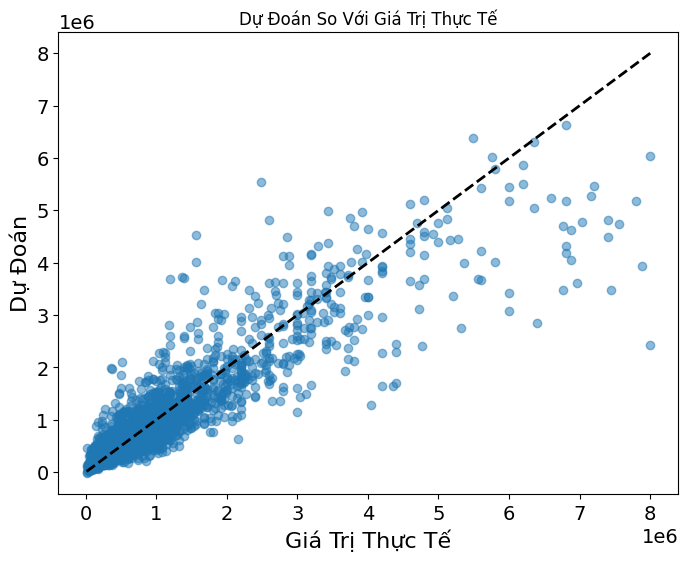

In [66]:
# Vẽ biểu đồ dự đoán so với giá trị thực tế
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_stacking, alpha=0.5)
plt.xlabel('Giá Trị Thực Tế')
plt.ylabel('Dự Đoán')
plt.title('Dự Đoán So Với Giá Trị Thực Tế')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

Độ chính xác của dự đoán:
- Đa số các điểm dữ liệu nằm gần đường chấm gạch, cho thấy rằng mô hình dự đoán khá chính xác cho hầu hết các giá trị bất động sản.  
- Tuy nhiên, có một số điểm nằm xa đường chấm gạch, đặc biệt là ở phía trên và phía dưới, cho thấy mô hình có thể đã dự đoán quá cao hoặc quá thấp so với giá trị thực tế cho những trường hợp này.  

Sai số dự đoán:  
- Sai số dường như lớn hơn khi giá trị thực tế cao hơn, tức là mô hình có xu hướng ít chính xác hơn khi giá trị nhà ở lớn.
- Những điểm xa đường thẳng giá thực tế = giá dự đoán có thể là những bất động sản có đặc điểm đặc biệt mà mô hình không nắm bắt được.
Kết luận:
- Mô hình dự đoán có độ chính xác tốt cho phần lớn các giá trị bất động sản.

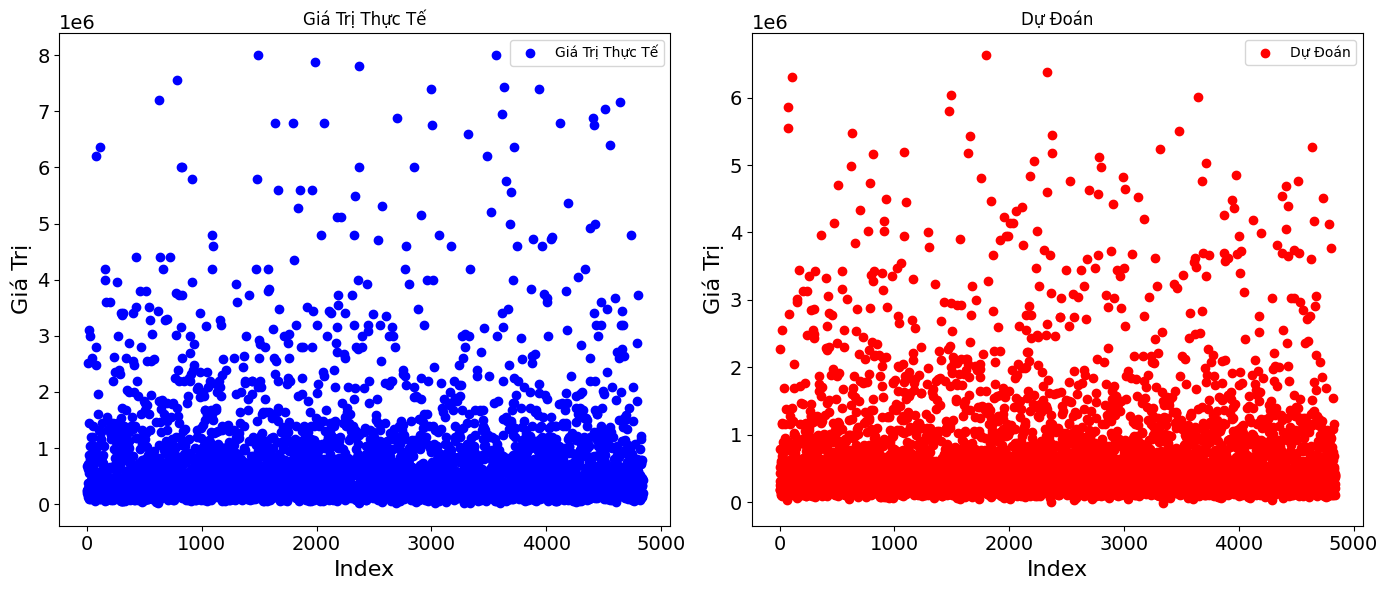

In [67]:
# Vẽ biểu đồ giá trị thực tế
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # 1 hàng, 2 cột, 1st subplot
plt.scatter(range(len(y_test)), y_test, color='blue', label='Giá Trị Thực Tế')
plt.xlabel('Index')
plt.ylabel('Giá Trị')
plt.title('Giá Trị Thực Tế')
plt.legend()

# Vẽ biểu đồ dự đoán
plt.subplot(1, 2, 2)  # 1 hàng, 2 cột, 2nd subplot
plt.scatter(range(len(y_pred_stacking)), y_pred_stacking, color='red', label='Dự Đoán')
plt.xlabel('Index')
plt.ylabel('Giá Trị')
plt.title('Dự Đoán')
plt.legend()

plt.tight_layout()
plt.show()

Phân bố giá trị:
- Cả giá trị thực tế và giá trị dự đoán đều có phân bố tương tự, với hầu hết các giá trị nằm dưới mức 2 triệu USD.  
- Có một số giá trị ngoại lai (outliers) ở các mức cao hơn 5 triệu USD, nhưng chúng tương đối ít.  

So sánh giữa dự đoán và giá trị thực tế:  
- Phân bố của các điểm trong cả hai biểu đồ rất giống nhau, cho thấy mô hình dự đoán đang phản ánh khá tốt giá trị thực tế.  

Kết luận:
- Mô hình dự đoán dường như hoạt động tốt với đa số các giá trị.